# **Project: Amazon Product Recommendation System**

Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

## **Importing the necessary libraries and overview of the dataset**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
#Import dataset
df = pd.read_csv('ratings_Electronics.csv',header=None)

df.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [5]:
#Add columns
df.columns = ['user_id','prod_id','rating','timestamp']

#Dropping timestamp, assuming time of review has no signficance
df = df.drop('timestamp',axis=1)

#Deep copy
df_copy = df.copy(deep=True)

df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [6]:
#Get general stats about the dataframe
df_copy.describe(include='all')

,user_id,prod_id,rating
count,7824482,7824482,7.824482e+06
unique,4201696,476002,NaN
top,A5JLAU2ARJ0BO,B0074BW614,NaN
freq,520,18244,NaN
mean,NaN,NaN,4.012337e+00
std,NaN,NaN,1.380910e+00
min,NaN,NaN,1.000000e+00
25%,NaN,NaN,3.000000e+00
50%,NaN,NaN,5.000000e+00
75%,NaN,NaN,5.000000e+00


## **Exploratory Data Analysis**

To build an effective recommendation system, there needs to be a balance between the amount for data users and product. Given there isn't a one-size-fits-all answer, I will be taking the following approach. 

I am assuming, products that are not reviewed often is either not popular or new in the store and hasn't been discovered yet. Given recommendation system models depend on historical data, it would not make sense to include these type of products in the learning dataset. 

Likewise, if the goal is to recommend procuts to customers based on their previous ratings for other products, it would make sense to not include users who have given very few reviews. 

Now to order of pruning products or users first from the learning dataset is extremely important. Whichever is pruned second may result in eliminating data points for the previous category. For example, lets say you first pruned products where the minimum data points avaliable for products is 50. When you then eliminate users with few data points from that dataset, its possible that the minimum data points available for products becomes less than 50.

Since, new products are untested I will remove them from the dataset first. Now the products remaining is guaranteed to have a minmimum amount of reviews. Futhermore, a "user" recommendation must have sufficient data per user. We are NOT building a recommendation system to promote new products. 

So, I will first products and then users.


In [7]:
#Get rating counts per product
product_rating_counts =  df_copy['prod_id'].value_counts().reset_index()
product_rating_counts.columns = ['prod_id','count']

In [8]:
product_rating_counts.describe()

,count
count,476002.000000
mean,16.437918
std,112.702633
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,18244.000000


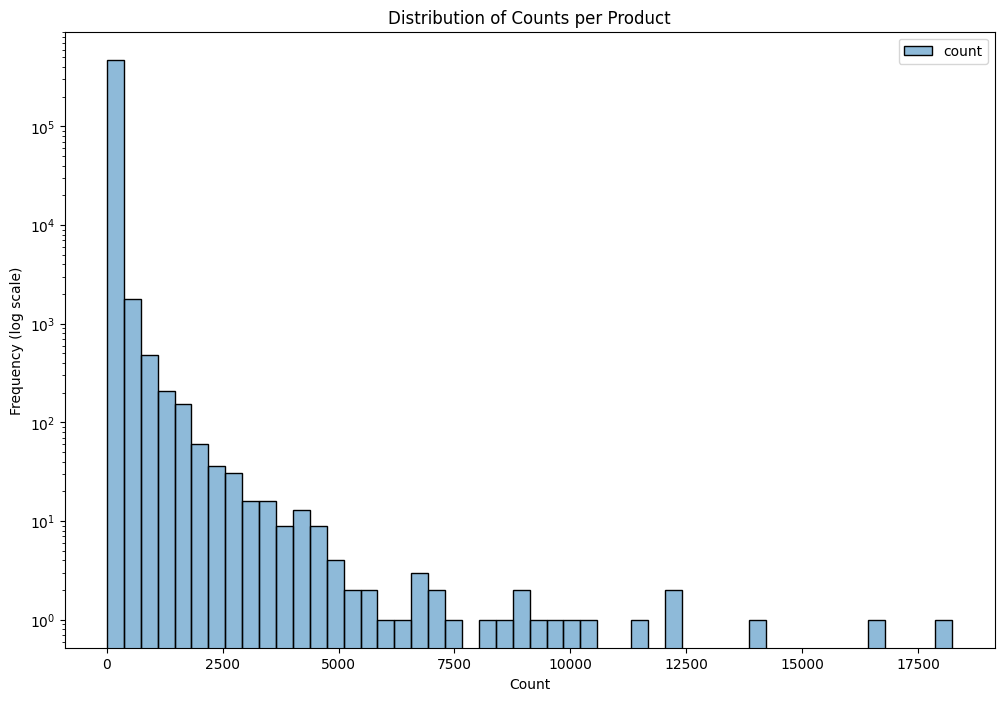

In [9]:
# Plotting the distribution of counts per product
plt.figure(figsize=(12, 8))
sns.histplot(product_rating_counts, bins=50, log_scale=(False, True), color='skyblue')
plt.title('Distribution of Counts per Product')
plt.xlabel('Count')
plt.ylabel('Frequency (log scale)')
plt.show()

In [10]:
skewness = product_rating_counts['count'].skew()

print("Skewness:",skewness)

Skewness: 51.913211164839126


There is a large positive skewness, meaning vast majority of the products have only one review. Hence, I will start by reducing the skewness by 3x. This is done, by removing all products with less than 50 percentile of product rating counts

In [11]:
#Create deep copy of product_rating_counts
product_rating_counts_copy = product_rating_counts.copy(deep=True)

#Define targe skewness
skewness = product_rating_counts_copy['count'].skew()
target_skewness = skewness / 3

#Keep removing products with less than 50th percentile review count until target skewness is achieved
while True:
    percentile_50 = product_rating_counts_copy['count'].quantile(0.5)
    product_rating_counts_copy = product_rating_counts_copy[product_rating_counts_copy['count'] > percentile_50]
    skewness = product_rating_counts_copy['count'].skew()
    if skewness < target_skewness:
        break

product_rating_counts_copy.describe()

,count
count,25758.000000
mean,207.737907
std,441.408929
min,51.000000
25%,68.000000
50%,102.000000
75%,191.000000
max,18244.000000


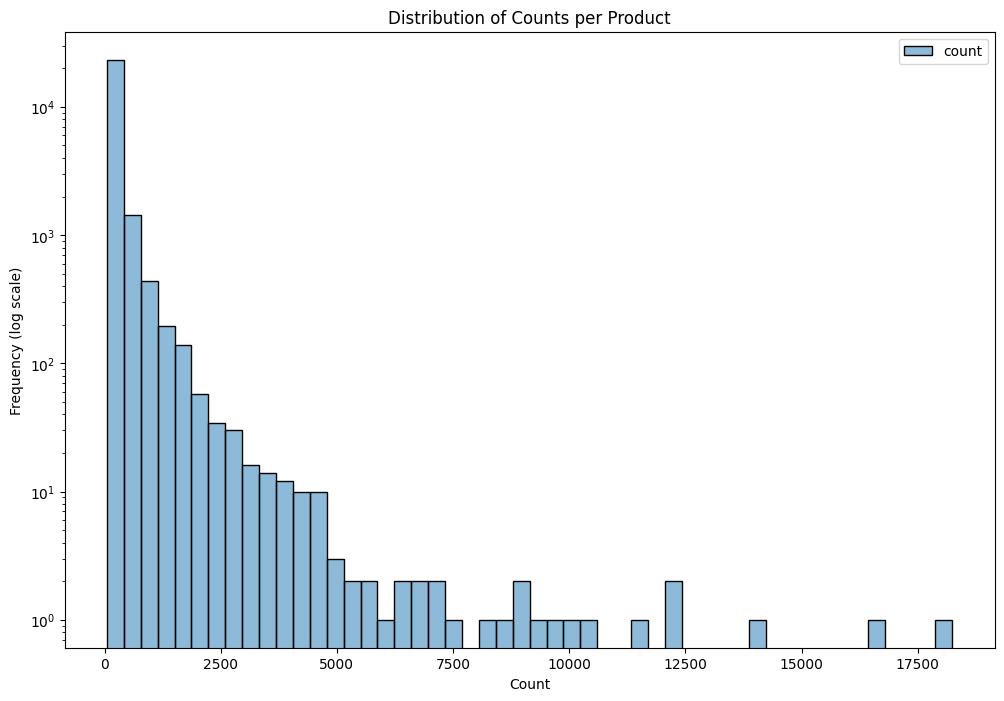

In [12]:
# Plotting the distribution of counts per product
plt.figure(figsize=(12, 8))
sns.histplot(product_rating_counts_copy, bins=50, log_scale=(False, True), color='skyblue')
plt.title('Distribution of Counts per Product')
plt.xlabel('Count')
plt.ylabel('Frequency (log scale)')
plt.show()

The minimum number of reviews seen for a given product is now 51.

In [13]:
#Remove all users with not in the new filtered list of products
filtered_df = df_copy[df_copy['prod_id'].isin(product_rating_counts_copy['prod_id'])]

Now I will prune data based on user rating counts using the same as pruning based on product rating counts

In [14]:
#Get count of ratings per user
user_rating_counts =  filtered_df['user_id'].value_counts().reset_index()
user_rating_counts.columns = ['user_id','count']

In [15]:
#Sanity check user_rating_counts dataframe
user_rating_counts.describe()

,count
count,3.214962e+06
mean,1.664378e+00
std,2.136329e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,3.100000e+02


In [16]:
skewness = user_rating_counts['count'].skew()
print("Skewness:",skewness)

Skewness: 19.269273403430173


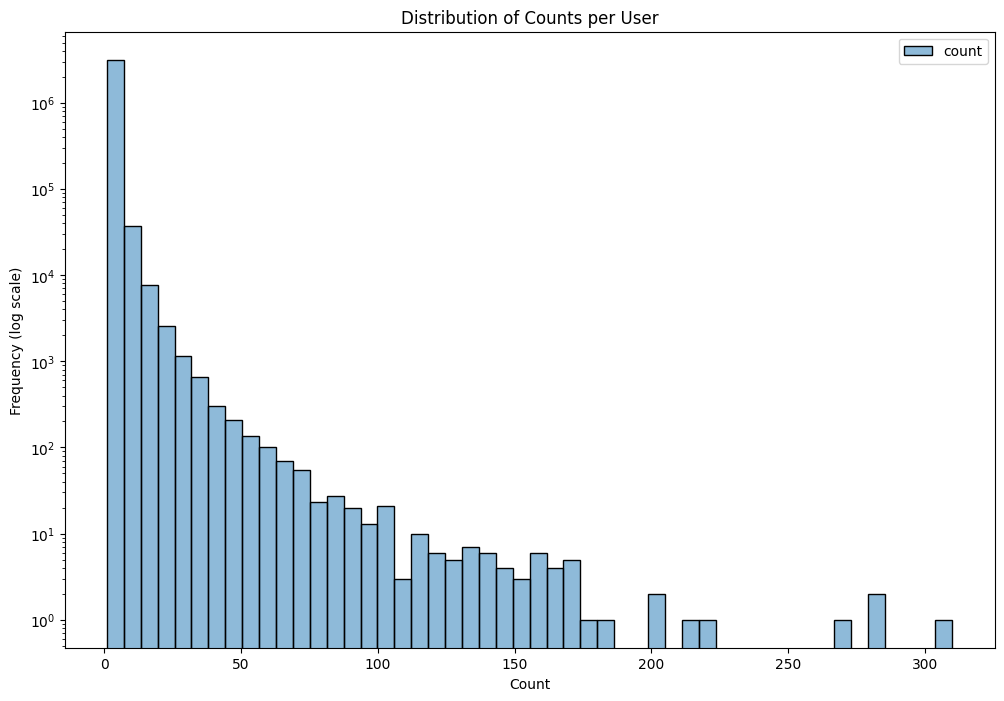

In [17]:
# Plotting the distribution of counts
plt.figure(figsize=(12, 8))
sns.histplot(user_rating_counts, bins=50, log_scale=(False, True), color='skyblue')
plt.title('Distribution of Counts per User')
plt.xlabel('Count')
plt.ylabel('Frequency (log scale)')
plt.show()

In [18]:
#Create deep copy of usering_rating_counts
user_rating_counts_copy = user_rating_counts.copy(deep=True)

In [19]:
#Find target skewness value
skewness = user_rating_counts['count'].skew()
target_skewness = skewness / 4
print(target_skewness)

4.817318350857543


In [20]:
#Keep removing users with less than 50th percentile count until target_skewness is achieved
while True:
    percentile_50 = user_rating_counts_copy['count'].quantile(0.5)
    user_rating_counts_copy = user_rating_counts_copy[user_rating_counts_copy['count'] > percentile_50]
    skewness = user_rating_counts_copy['count'].skew()
    if skewness < target_skewness:
        break

In [21]:
user_rating_counts_copy.describe()

,count
count,2854.000000
mean,41.698669
std,23.690705
min,26.000000
25%,29.000000
50%,34.000000
75%,45.000000
max,310.000000


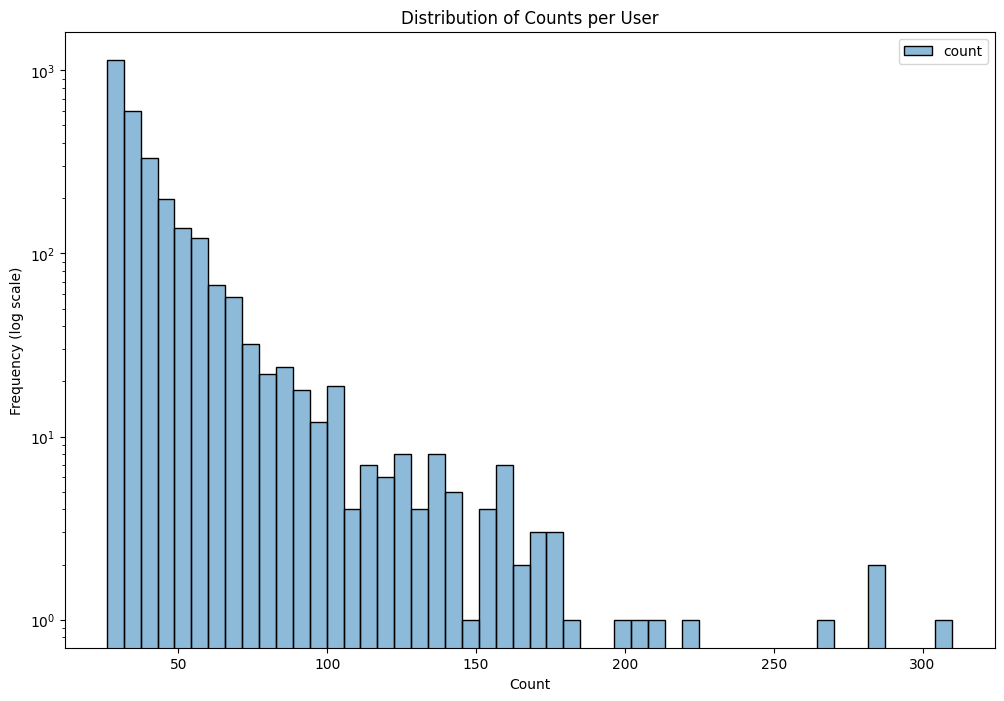

In [22]:
# Plotting the distribution of counts
plt.figure(figsize=(12, 8))
sns.histplot(user_rating_counts_copy, bins=50, log_scale=(False, True), color='skyblue')
plt.title('Distribution of Counts per User')
plt.xlabel('Count')
plt.ylabel('Frequency (log scale)')
plt.show()

In [23]:
#Remove all users with not in the new filtered list of users
filtered_df = df_copy[df_copy['user_id'].isin(user_rating_counts_copy['user_id'])]

In [24]:
# Number of total rows in the data and number of unique user id and product id in the data
print('The number of observations in the filtered data is ', len(filtered_df), '. Compared to the initial observation of ', len(df_copy) )
print('Number of unique users in filtered data is ', filtered_df['user_id'].nunique(), ' with minimum count of ', filtered_df['user_id'].value_counts().min(), 'per user')
print('Number of unique items in filtered data is ', filtered_df['prod_id'].nunique(), ' with minimum count of ', filtered_df['prod_id'].value_counts().min(), 'per item')

The number of observations in the filtered data is  176739 . Compared to the initial observation of  7824482
Number of unique users in filtered data is  2854  with minimum count of  27 per user
Number of unique items in filtered data is  56441  with minimum count of  1 per item


The new transformed dataset has been reduce by over 40 times, making it more computationally feasible to build user recommendation system.

Now I will do some basically exploratory data analysis

<Axes: xlabel='rating'>

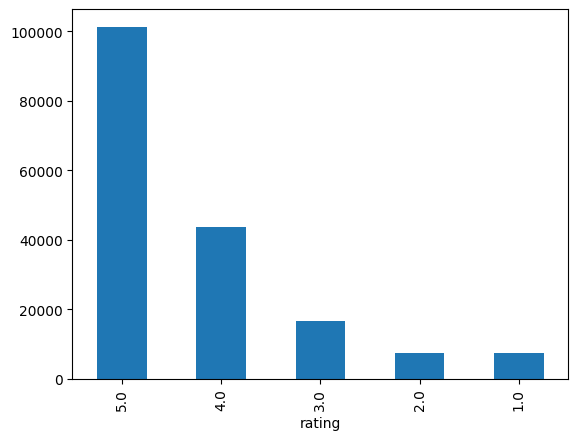

In [25]:
#Check rating distribution
filtered_df['rating'].value_counts().plot(kind='bar')

It appears vast majority of the ratings are 5

<Axes: xlabel='user_id'>

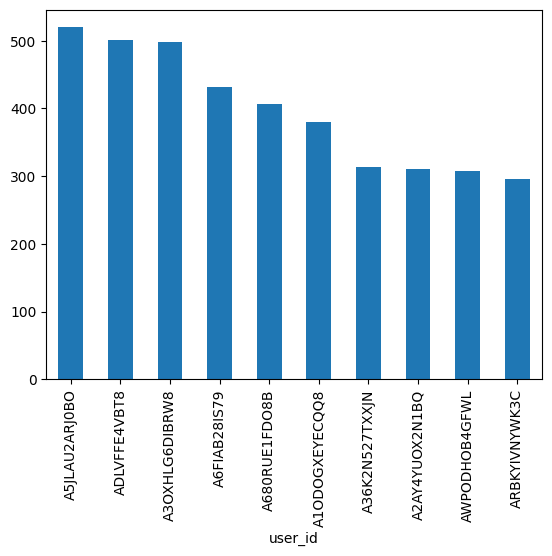

In [26]:
#Check the top ten users with the most rating
filtered_df['user_id'].value_counts().head(10).plot(kind='bar')


The user with the highest number of rating counts is ~500, which is signficiantly less than total number of unique products. This fact allows us to build an recommendation system to users they have not interacted with. 

In [27]:
#Create a copy of filtered_dat as the final dataset to be used for building models
df_final = filtered_df.copy(deep=True)

## **Model 1: Rank Based Recommendation System**

In [28]:
df_final.head()

,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
200,A3BMUBUC1N77U8,0972683275,4.0


Recommend products based on average rating

In [29]:
#Create dataframe with average rating and count of rating per product
agg_rating = df_final.groupby('prod_id')['rating'].agg(['mean','count']).reset_index()
agg_rating.columns = ['prod_id', 'average_rating', 'rating_count']

In [30]:
agg_rating.head()

,prod_id,average_rating,rating_count
0,0594451647,5.000000,1
1,0594481813,3.000000,1
2,0970407998,2.500000,2
3,0972683275,4.692308,13
4,1400501466,3.571429,7


In [31]:
#Create function to get the top n products based on highest average rating and minimum interactions

def top_n_products(agg_rating,n,min_interaction):

    # Find products with minimum number of interactions
    recommendations = agg_rating[agg_rating['rating_count'] >= min_interaction]


    # Sort values with respect to the average rating
    recommendations = recommendations.sort_values(by='average_rating',ascending=False)

    return recommendations[:n]

Recommending top 5 products with minimum interactions based on popularity (rating)

In [32]:
#Top 5 with 50 minimum iteractions
top_50 = top_n_products(agg_rating,5,50)

top_50.head()

,prod_id,average_rating,rating_count
36851,B0052SCU8U,4.958763,97
25807,B00316263Y,4.915493,71
20937,B001TH7T2U,4.887324,71
20934,B001TH7GUU,4.875912,137
51026,B00BQ4F9ZA,4.870968,62


In [33]:
#Top 5 with 100 minimum iteractions
top_100 = top_n_products(agg_rating,5,100)

top_100.head()

,prod_id,average_rating,rating_count
20934,B001TH7GUU,4.875912,137
27932,B003ES5ZUU,4.866044,321
20930,B001TH7GSW,4.863636,110
17085,B0019EHU8G,4.802395,167
12947,B000QUUFRW,4.778571,140


## **Model 2: Collaborative Filtering Recommendation System**

In [34]:
#Import libraries
from surprise import accuracy
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

from collections import defaultdict

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

from surprise.model_selection import GridSearchCV

In [35]:
df_final.head()

,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
200,A3BMUBUC1N77U8,0972683275,4.0


In [36]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176739 entries, 94 to 7824444
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  176739 non-null  object 
 1   prod_id  176739 non-null  object 
 2   rating   176739 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.4+ MB


In [37]:
#Instanitating train and test dataset using the Suprise library
reader = Reader(rating_scale = (0, 5))

data = Dataset.load_from_df(df_final[['user_id','prod_id','rating']], reader)

trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

### **Creating a user-user similarity based recommendation system**

In [38]:
#Create a KNN model using cosime similarity as a distance metric

#Setting KNN model to compute similarity between users based on cosine as the distance metric 
sim_options = {'name': 'cosine',
               'user_based': True}

#Initialize the model using sim_optiosn provided
sim_user_user = KNNBasic(sim_options=sim_options,verbose=False,random_state=1)

#Fit the model on the training data
sim_user_user.fit(trainset)

#Make predictions on test dataset
prediction = sim_user_user.test(testset)

- uid: User ID for the prediction.
- iid: Item ID for the prediction.
- r_ui: True rating (if available in the test set).
- est: Estimated rating (the predicted rating).
- details: Additional details about the prediction.

Now we will compute the precisions and recall scores. Since we only clear about the top predictions, only those predictions will be used in the computation

In [39]:
#This is a function to claculate precisions and recall score for the top k predictions per user with rating greater than some threshold value
def calc_metrics_top_k(prediction,k,threshold):

    #Create dictionary for estminated and true ratings per user
    user_est_true = defaultdict(list)
    for uid, _, r_ui, est, _ in prediction:
        user_est_true[uid].append((est,r_ui))

    #Store precision and recall scores
    precisions = dict()
    recalls = dict()

    for uid, ratings in user_est_true.items():

        #Sort estimated ratings in descending order
        ratings.sort(key= lambda x: x[0], reverse = True)

        #Get the number of true positive ratings with value greater than threshold
        true_positives = sum((r_ui >= threshold) for (_,r_ui) in ratings)

        #Get the number of estimated ratings with value greater than threshold in top k
        est_positives = sum((est >= threshold) for (est,_) in ratings[:k])

        #Get the number of true and estimated items in top k above the threshold
        true_est_positives = sum(((r_ui >= threshold) and (est >= threshold))
                              for (est, r_ui) in ratings[:k])

        #Calculate precision 
        precisions[uid] = true_est_positives / est_positives if est_positives != 0 else 0

        #Calculate recall
        recalls[uid] = true_est_positives / true_positives if true_positives != 0 else 0

    # Get average predicted precisions
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Get average predicted recalls
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Get the average F-1 Score
    f1_score = round((2*precision*recall)/(precision+recall), 3)
    
    accuracy.rmse(prediction)
    print('Precision: ', precision) 
    print('Recall: ', recall)
    print('F_1 score: ', f1_score)



In [40]:
# Use the trained model to make predictions on test data and output the metrics
calc_metrics_top_k(prediction,10,3.5)

RMSE: 1.1297
Precision:  0.838
Recall:  0.816
F_1 score:  0.827


The precision and recall score is quite balanced. 

Now I'm creating a get function to get the top n product recommendations for a given user. Note the products recommend are all products the user hasn't not yet purchased

In [125]:
def get_recommendations(data, user_id, top_n, model):
       
    # Create user-product interaction list for just the products the user has not interacted with yet
    user_item_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    non_interacted_list = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id].isnull()].index.tolist()

    # Empty list to store recommended products per user
    recommendations = []
    
    # Get estimated predicted rating for all non-iteracted products for user_id
    for item_id in non_interacted_list:
        est = model.predict(user_id, item_id).est
        recommendations.append((item_id, est))

    # Sort predicted ratings in descending order and return the top n highest predicted rating products for user_id
    recommendations.sort(key = lambda x: x[1], reverse = True)

    top_recommendations = pd.DataFrame(recommendations[:top_n], columns = ['prod_id', 'predicted_ratings'])

    # Filter DataFrame to include only rows with the target prod_id
    top_recommendations['avg_rating'] = [df_final[df_final['prod_id'] == prod_id]['rating'].mean() for prod_id in top_recommendations['prod_id']]

    return top_recommendations


In [126]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user)

recommendations

,prod_id,predicted_ratings,avg_rating
0,0594451647,5,5.0
1,1685560148,5,5.0
2,8862935307,5,5.0
3,9573212919,5,5.0
4,9800359788,5,5.0


It appears the avg ratings for the top 5 recommended products is 5. There isn't much I can comment of the product, since I don't know what they are.

### **Improving Similarity-based Recommendation System by tuning its hyperparameters**

We will tune the hyperparemeters for KNN algorithm in attempts to find the best number of neighbors to account for in predictions

In [132]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [25, 50, 100, 150, 200, 250, 300],  # Number of neighbors
              'min_k' : [25],
              'sim_options': {'name': ['cosine'],
                              'user_based': [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0683472354867227
{'k': 150, 'min_k': 25, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [133]:
#Create a KNN model using cosime similarity as a distance metric

#Setting KNN model to compute similarity between users based on cosine as the distance metric 
sim_options = {'name': 'cosine',
               'user_based': True}

#Initialize the model using sim_optiosn provided
sim_user_user_optimized = KNNBasic(sim_options=sim_options,k=150,min_k=25,verbose=False,random_state=1)

#Fit the model on the training data
sim_user_user_optimized.fit(trainset)

#Make predictions on test dataset
prediction = sim_user_user_optimized.test(testset)

calc_metrics_top_k(prediction,10,3.5)

RMSE: 1.0694
Precision:  0.82
Recall:  0.833
F_1 score:  0.826


The new hypertuned parameters provided a better recall score of 0.833 while sacrifising a lower precision of 0.82. Since the cost of missing potential sales is greater than recommending undesirable products to the users, a higher recall score is more important than precision.

In [145]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

recommendations

,prod_id,predicted_ratings,avg_rating
0,B001TH7GUU,5.000000,4.875912
1,B003ES5ZUU,4.904716,4.866044
2,B002WE6D44,4.809372,4.768041
3,B007WTAJTO,4.782612,4.679612
4,B001XURP7W,4.684061,4.422414


The hypertuned model appears to be recommending products with avg rating lower than 5. This is likely do the the increase in minimum number of neighbors from the baseline model.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

We will now build an recommendation system based on simiarlity between items

In [138]:
#Create a KNN model using cosime similarity as a distance metric between items

#Setting KNN model to compute similarity between users based on cosine as the distance metric 
sim_options = {'name': 'cosine',
               'user_based': False}

#Initialize the model using sim_optiosn provided
sim_item_item = KNNBasic(sim_options=sim_options,verbose=False,random_state=1)

#Fit the model on the training data
sim_item_item.fit(trainset)

#Make predictions on test dataset
prediction = sim_item_item.test(testset)

calc_metrics_top_k(prediction,10,3.5)

RMSE: 1.1074
Precision:  0.822
Recall:  0.806
F_1 score:  0.814


In [146]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_item_item)

recommendations

,prod_id,predicted_ratings,avg_rating
0,0594451647,5,5.0
1,0594481813,5,3.0
2,9573212900,5,4.0
3,9573212919,5,5.0
4,9983722615,5,5.0


The precision and recall score for collaborative filteirng based on item-item is lower than user-user. This does make sense, considering the dataset used for training and testing is prioritized for user-user interactions

### **Hyperparameter tuning the item-item similarity-based model**

In [147]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30],  # Number of neighbors
              'min_k' : [3,6,9],
              'sim_options': {'name': ['cosine'],
                              'user_based': [False]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=2, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

MemoryError: Unable to allocate 9.98 GiB for an array with shape (36597, 36597) and data type float64

It appears that I have ran into a memory issue. This makes sense given there is ~20 times more products than users. Once again, given we are much more focused on user-user interactions than item-item as mentioned previously, I don't see the need to continue forward with tuning item-item model.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [149]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

predictions = svd.test(testset)

calc_metrics_top_k(prediction,10,3.5)

RMSE: 1.1074
Precision:  0.822
Recall:  0.806
F_1 score:  0.814


Lets check spot a a few predictions for given user and product

In [150]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.044625822702099, details={'was_impossible': False})

Thus far the svd model indicated similar performance as compared to KNN based models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

In [153]:
# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

In [155]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])


0.9894837781901117
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


In [156]:
# Using SVD matrix factorization. Use random_state = 1
svd_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the train set
svd_optimized.fit(trainset)

predictions = svd_optimized.test(testset)

calc_metrics_top_k(prediction,10,3.5)

RMSE: 1.1074
Precision:  0.822
Recall:  0.806
F_1 score:  0.814


In [161]:
# Making prediction
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.05   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.045339591872753, details={'was_impossible': False})

The hypertuned parametered does seem to have made any signficiant components to the base line model

### **Conclusion and Recommendations**

- If the goal is to provide the best recommendations to users, it best to only recommend products that have been rated highly by many users who are similar in product choices. As such I would recommend to using the optimized KNN based model for user-user interaction.
- Now if you want to promote newer untested products to users, it would make sense to gather more product related data and find products similar to the highly rated and recommend products. In addition, the company can charge companies of the newer products to promote their products.

- In short, recommending new products and popular products should be done by separately as these tasks require different sets of data